# Feature Engineering Project

# Part (A) Data Collection through Web-Scraping

In [1]:
# Import required libs
import re, time, random
import pandas as pd
import numpy as np
import seaborn as sb
import requests, json
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.chrome.options import Options
from urllib.request import urlopen
from bs4 import BeautifulSoup

# Scraping from simplinamdhari's
url = "https://www.simplinamdharis.com/home"

# Execute on Chrome to run and convert all the dynamic content into HTML
options = Options()
options.add_argument('--headless')
chrome = webdriver.Chrome(options=options)#,executable_path='')
chrome.get(url)

# Save the homepage
chrome.save_screenshot('home.png')

# Wait for full page load
chrome.execute_script("window.scrollTo(0,document.body.scrollHeight);var pageLen=document.body.scrollHeight;return pageLen;")
# Wait a bit more
time.sleep(5)

# Find all the main categories and create a reference category URL map
category_list = chrome.find_elements_by_class_name("shop-by-catogories")
linkMap = {link.get_attribute('href'):link.find_element_by_class_name('catogories-main-text').text for link in category_list}

# Check the scraped data
for k, v in linkMap.items():
    print(f'{v:25}{k}')
    
# Close the session and browser
chrome.quit()

Fruits & Vegetables      https://www.simplinamdharis.com/category/1
Beverages                https://www.simplinamdharis.com/category/53
Branded Foods            https://www.simplinamdharis.com/category/92
Grocery & Staples        https://www.simplinamdharis.com/category/270
Healthy Food             https://www.simplinamdharis.com/category/430
Gourmet & Imported       https://www.simplinamdharis.com/category/241
Household                https://www.simplinamdharis.com/category/356
Personal Care            https://www.simplinamdharis.com/category/407


In [2]:
# URL for backend calls figured from the AJAX calls on network data inspection
apiUrl = "https://cdn.simplinamdharis.com/namdhari/api1/item/product"
# Data content for POST with the data filters set to fetch all data in one pull, can be iterative as well
params = {"_id":"0","_session":"NKTyvBDYLZzUjpCM_27392020063909999","wh_pincode":"560004","id_subcategory":"1","brand":"",
          "price":"0,100000","sort":"","start":0,"count":10000,"express":0}

# Get the API dump of all data segments instead of parsing through HTML
rawAPIResponse = []
scrapeCount = 0
for i, (k,v) in enumerate(linkMap.items()):
    subcategory = k.split('/')[-1]
    params['_session'] = random.randrange(int(subcategory))
    params['id_subcategory'] = subcategory
    
    response = requests.post(apiUrl, data=json.dumps(params),)
    print('Scraped JSON data for {}'.format(v))
    print('Response Metadata: {}'.format((response.status_code, response.reason,
                                          str(round(response.elapsed.total_seconds(), 2)) + ' seconds')))
    rawAPIResponse.append(response.json())
    
    # Dump all data into individual json/txt files to build pandas dataframes later
    if response.ok:
        with open(v + '.txt', 'w') as jsonData:
            json.dump(rawAPIResponse[i], jsonData, indent=4, sort_keys=True,)
            scrapeCount += rawAPIResponse[i]['total_sku']
            print('Dumped JSON into: {}.txt'.format(v))
            print('Scraped units: {}\n'.format(rawAPIResponse[i]['total_sku']))
        
print('Total Data Scraped: ', scrapeCount)

Scraped JSON data for Fruits & Vegetables
Response Metadata: (200, 'OK', '2.02 seconds')
Dumped JSON into: Fruits & Vegetables.txt
Scraped units: 140

Scraped JSON data for Beverages
Response Metadata: (200, 'OK', '6.71 seconds')
Dumped JSON into: Beverages.txt
Scraped units: 274

Scraped JSON data for Branded Foods
Response Metadata: (200, 'OK', '15.75 seconds')
Dumped JSON into: Branded Foods.txt
Scraped units: 952

Scraped JSON data for Grocery & Staples
Response Metadata: (200, 'OK', '8.71 seconds')
Dumped JSON into: Grocery & Staples.txt
Scraped units: 564

Scraped JSON data for Healthy Food
Response Metadata: (200, 'OK', '0.52 seconds')
Dumped JSON into: Healthy Food.txt
Scraped units: 30

Scraped JSON data for Gourmet & Imported
Response Metadata: (200, 'OK', '2.17 seconds')
Dumped JSON into: Gourmet & Imported.txt
Scraped units: 110

Scraped JSON data for Household
Response Metadata: (200, 'OK', '4.07 seconds')
Dumped JSON into: Household.txt
Scraped units: 238

Scraped JSON da

In [3]:
# Scraping could also be done using Selenium as below
# Will need to simulate clicking the button till all records are loaded
# Time increases and need rigorous exception handling for time-outs and other conditions
# Will also need to simulate drop-down selects and select the data as different records
# Intead follow the API approach above and get a webhook/handle on the GET/POST APIs
# This will give then entire formatted JSON/XML data which goes into different parts of the HTML through JavaScript
# Will also need to check for hidden classes/divs with the below approach
# driver.find_elements_by_class_name('product-item clearfix') - this is hidden, find the parent and iterate
# Will also need to handle Stale issues that arise when DOM changes due to JS loads

# rawHTMLResponse = []
# for i, (k,v) in enumerate(linkMap.items()):
#     allItemsLoaded = False
#     totalClicks = 0
#     chrome = webdriver.Chrome(options=options)
#     chrome.get(k)
#     while(not allItemsLoaded):
#         try:
#             WebDriverWait(chrome, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, 'load-more')))
#             # There is only one element for loading more items on the page, find and click it
#             if totalClicks == 0:
#                 # Wait for a couple of seconds
#                 time.sleep(5)
#                 chrome.save_screenshot(v + '.png')
#             chrome.find_elements_by_class_name("load-more")[0].click()
#             totalClicks += 1
#         except TimeoutException:
#             allItemsLoaded = True
#     print('Total Clicks for ' + v + ':', totalClicks)
#     rawHTMLResponse.append(chrome.page_source)
    
    # Algorithm goes on to parse all items in the current session
    # We need to inspect, find element and loop through, also iterate items having dropdown and add them to the item list
    # Skipping this exercise further
    # chrome.close()
# Keeping the approach here

# Part (B) Data Pre-Processing and Cleaning

In [4]:
# Store all scraped data into a dataframe array
# DFs will be merged later with a column index
# API data has metadata which gives the total records
# This verification has been done below
# Products have line items which are captured in the dataframe rows
dfArr = []
for i in range(len(rawAPIResponse)):
    rowCount = 0
    data = rawAPIResponse[i]['product']
    total_sku = rawAPIResponse[i]['total_sku']
    if(total_sku == len(data)):
        print('Records and metadata match:', total_sku, end='\t\t')
    for j in range(len(data)):
        rowCount += len(rawAPIResponse[i]['product'][j]['sku'])
    print('Total rows:', rowCount)
    meta = [k for k in data[0] if k!='sku']
    dfArr.append(pd.json_normalize(data, 'sku', meta, meta_prefix='p_', errors='raise'))

Records and metadata match: 140		Total rows: 191
Records and metadata match: 274		Total rows: 281
Records and metadata match: 952		Total rows: 989
Records and metadata match: 564		Total rows: 617
Records and metadata match: 30		Total rows: 35
Records and metadata match: 110		Total rows: 114
Records and metadata match: 238		Total rows: 249
Records and metadata match: 262		Total rows: 271


In [5]:
# Luckily there were no errors in flattening the JSON or creating the dataframe
# Check the data of an arbitrary dataframe
display(dfArr[6].head(3), dfArr[3].tail(2))

,_id,box_color,filter_color,id_product,is_restaurant,min_quantity,mrp,mycart,offer,realization,...,p_category3_id,p_description,p_id_category,p_mrp,p_name,p_pic,p_selling_price,p_spec,p_tags,p_wishlist
0,2292985,None,None,62671,0,1,215,0,,127.54,...,1014,,1014,0,Paseo Smart 6X1 Toilet Roll 200 Sheets,"[{'_id': '97481', 'pic': 'uploads/product/2145...",0,"[{'_id': '1235518', 'specification': 'About', ...",Toilet Roll,0
1,2120430,None,None,58757,0,1,65,0,,38.55,...,1014,SMART SERVIETTES,1014,0,SMART SERVIETTES,"[{'_id': '97479', 'pic': 'uploads/product/2086...",0,"[{'_id': '1252107', 'specification': 'Descript...",SMART SERVIETTES,0
2,2129316,None,None,62103,0,1,12,0,,6.85,...,599,Haldi 15 Gm Pouch,599,0,Haldi 15 Gm Pouch,"[{'_id': '93434', 'pic': 'uploads/product/2146...",0,"[{'_id': '1206919', 'specification': 'Descript...",OM BHAKTI,0


,_id,box_color,filter_color,id_product,is_restaurant,min_quantity,mrp,mycart,offer,realization,...,p_category3_id,p_description,p_id_category,p_mrp,p_name,p_pic,p_selling_price,p_spec,p_tags,p_wishlist
615,2120049,None,None,58348,0,1,118,0,,87.66,...,686,CHAAT MASALA,686,0,CHAAT MASALA,"[{'_id': '74949', 'pic': ' uploads/product/210...",0,"[{'_id': '1233084', 'specification': 'About', ...",CHAAT MASALA,0
616,2119854,None,None,58348,0,1,62,0,,46.06,...,686,CHAAT MASALA,686,0,CHAAT MASALA,"[{'_id': '74949', 'pic': ' uploads/product/210...",0,"[{'_id': '1233084', 'specification': 'About', ...",CHAAT MASALA,0


In [6]:
# Check that the columns are consistent and ready for merge
for i in range(len(dfArr)):
    print(list(dfArr[i].columns) == list(dfArr[i-1].columns), (i,i-1), end='\t')

True (0, -1)	True (1, 0)	True (2, 1)	True (3, 2)	True (4, 3)	True (5, 4)	True (6, 5)	True (7, 6)	

In [7]:
# Merge the dataframes into one dataframe for further processing and cleaning
# We should have 2747 rows and 35 colums as per our previous data analysis
fmcg = pd.concat([df for df in dfArr], ignore_index=True)
print('Scraped Data Information')
print("""Size - {}
Shape - {}
Dimensions - {}
""".format(fmcg.size, fmcg.shape, fmcg.ndim))
fmcg.info()

# Save to CSV file and avoid going back to the website
fmcg.to_csv('simpli_raw.csv', header=True, index=False)

Scraped Data Information
Size - 96145
Shape - (2747, 35)
Dimensions - 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   _id                  2747 non-null   object 
 1   box_color            0 non-null      object 
 2   filter_color         0 non-null      object 
 3   id_product           2747 non-null   object 
 4   is_restaurant        2747 non-null   object 
 5   min_quantity         2747 non-null   object 
 6   mrp                  2747 non-null   object 
 7   mycart               2747 non-null   object 
 8   offer                2747 non-null   object 
 9   realization          2747 non-null   object 
 10  selling_price        2747 non-null   float64
 11  size                 2747 non-null   object 
 12  size_measuring_unit  0 non-null      object 
 13  sku                  2747 non-null   object 
 14  stock          

In [8]:
# You can run the evaluation from here, uncomment reading csv again (note: None values may be shown as NaN)
# fmcg = pd.read_csv('simpli_raw.csv')
# Duplicate check (there are 37)
print(fmcg.duplicated(subset='sku').sum())
# Let's check the duplicates
fmcg[fmcg.sku.isin(fmcg[fmcg.duplicated(subset='sku')]['sku'].values.tolist())].sort_values('sku').head(6)

37


,_id,box_color,filter_color,id_product,is_restaurant,min_quantity,mrp,mycart,offer,realization,...,p_category3_id,p_description,p_id_category,p_mrp,p_name,p_pic,p_selling_price,p_spec,p_tags,p_wishlist
939,2117434,None,None,53307,0,1,149,0,,99.76,...,591,PERI PERI SAUCE,591,0,PERI PERI SAUCE,"[{'_id': '74482', 'pic': 'uploads/product/1436...",0,"[{'_id': '363954', 'specification': 'About', '...",PERI PERI SAUCE,0
2160,2117434,None,None,53307,0,1,149,0,,99.76,...,591,PERI PERI SAUCE,591,0,PERI PERI SAUCE,"[{'_id': '74482', 'pic': 'uploads/product/1436...",0,"[{'_id': '363954', 'specification': 'About', '...",PERI PERI SAUCE,0
2162,2117388,None,None,53309,0,1,129,0,,86.38,...,591,SWEET ONION SAUCE,591,0,SWEET ONION SAUCE,"[{'_id': '74483', 'pic': 'uploads/product/1438...",0,"[{'_id': '361174', 'specification': 'About', '...",SWEET ONION SAUCE,0
990,2117388,None,None,53309,0,1,129,0,,86.38,...,591,SWEET ONION SAUCE,591,0,SWEET ONION SAUCE,"[{'_id': '74483', 'pic': 'uploads/product/1438...",0,"[{'_id': '361174', 'specification': 'About', '...",SWEET ONION SAUCE,0
230,2118138,None,None,56545,0,1,275,0,,196.43,...,930,MILK CHOCOLATE NUTTY & DELICIOUS,930,0,MILK CHOCOLATE NUTTY & DELICIOUS,"[{'_id': '97178', 'pic': 'uploads/product/almo...",0,"[{'_id': '1232059', 'specification': 'Descript...",MILK CHOCOLATE NUTTY & DELICIOUS,0
2088,2118138,None,None,56545,0,1,275,0,,196.43,...,930,MILK CHOCOLATE NUTTY & DELICIOUS,930,0,MILK CHOCOLATE NUTTY & DELICIOUS,"[{'_id': '97178', 'pic': 'uploads/product/almo...",0,"[{'_id': '1232059', 'specification': 'Descript...",MILK CHOCOLATE NUTTY & DELICIOUS,0


In [9]:
# Indeed those are duplicated and we will drop one of them
fmcg.drop_duplicates(subset='sku', inplace=True, keep='last', ignore_index=True)
fmcg.duplicated(subset='sku').sum()

0

In [10]:
# Lets reduce the dimensions from 35, taking a look at the columns and data-types above
# Take a peek at the data to reduce most of the columns that are IDs, null, etc.
print(list(fmcg.columns))
pd.set_option('display.max_columns', None)
fmcg.head(3)

['_id', 'box_color', 'filter_color', 'id_product', 'is_restaurant', 'min_quantity', 'mrp', 'mycart', 'offer', 'realization', 'selling_price', 'size', 'size_measuring_unit', 'sku', 'stock', 'tax', 'p__id', 'p_actual_price', 'p_article_no', 'p_brand', 'p_category1', 'p_category1_id', 'p_category2', 'p_category2_id', 'p_category3', 'p_category3_id', 'p_description', 'p_id_category', 'p_mrp', 'p_name', 'p_pic', 'p_selling_price', 'p_spec', 'p_tags', 'p_wishlist']


,_id,box_color,filter_color,id_product,is_restaurant,min_quantity,mrp,mycart,offer,realization,selling_price,size,size_measuring_unit,sku,stock,tax,p__id,p_actual_price,p_article_no,p_brand,p_category1,p_category1_id,p_category2,p_category2_id,p_category3,p_category3_id,p_description,p_id_category,p_mrp,p_name,p_pic,p_selling_price,p_spec,p_tags,p_wishlist
0,2118849,None,None,58013,0,1,99,0,,70,99.0,1 KG,None,1005859,266,0,58013,0,800010700,NAMDHARI,Fruits and Vegetables,1,Mango Bazar,1009,Mango Bazar,1010,MANGO MALLIKA,1010,0,MANGO MALLIKA,"[{'_id': '97538', 'pic': 'uploads/product/mang...",0,"[{'_id': '1238149', 'specification': 'Descript...",MANGO MALLIKA,0
1,2118864,None,None,56232,0,1,20,0,,17,20.0,250 GM,None,1004066,237,0,56232,0,800010700,NAMDHARI,Fruits and Vegetables,1,Fresh Vegetables,29,LEAFY VEGETABLES,37,PALAK LEAF,37,0,PALAK LEAF,"[{'_id': '72102', 'pic': 'uploads/product/pala...",0,"[{'_id': '1016037', 'specification': 'Benefits...",PALAK LEAF,0
2,2118850,None,None,58017,0,1,50,0,,40,50.0,1 KG,None,1005863,209,0,58017,0,800010700,NAMDHARI,Fruits and Vegetables,1,Mango Bazar,1009,Mango Bazar,1010,MANGO SINDHURAN,1010,0,MANGO SINDHURAN,"[{'_id': '97545', 'pic': 'uploads/product/mang...",0,"[{'_id': '1238574', 'specification': 'Descript...",MANGO SINDHURAN,0


In [11]:
# There's too many data to reduce, let's keep dropping irrelevant ones
# First round of filtering obviously useless columns

#1  _id                   --> random ID column, discard
#2  box_color             --> none
print('box_color', fmcg.box_color.unique())
#3  filter_color          --> none
print('filter_color', fmcg.filter_color.unique())
#4  id_product            --> keep for now
#5  is_restaurant         --> 1
print('is_restaurant', fmcg.is_restaurant.unique())
#6  min_quantity          --> 1
print('min_quantity', fmcg.min_quantity.unique())
#7  mrp                   --> keep for now
#8  mycart                --> 0
print('mycart', fmcg.mycart.unique())
#9  offer                 --> blank
print('offer', fmcg.offer.unique())
#10 realization           --> keep for now
#11 selling_price         --> keep for now
#12 size                  --> keep for now
#13 size_measuring_unit   --> none
print('size_measuring_unit', fmcg.size_measuring_unit.unique())
#14 sku                   --> keep for now
#15 stock                 --> keep for now
#16 tax                   --> keep for now
#17 p__id                 --> same as id_product
print('p__id', fmcg[fmcg.p__id != fmcg.id_product].shape[0])
#18 p_actual_price        --> 0
print('p_actual_price', fmcg.p_actual_price.unique())
#19 p_article_no          --> looks internal, discard
#20 p_brand               --> keep for now
#21 p_category1           --> keep for now
#22 p_category1_id        --> keep for now
#23 p_category2           --> keep for now
#24 p_category2_id        --> keep for now
#25 p_category3           --> keep for now
#26 p_category3_id        --> keep for now
#27 p_description         --> keep for now
#28 p_id_category         --> p_category3_id
print('p_id_category', fmcg[fmcg.p_category3_id != fmcg.p_id_category].shape[0])
#29 p_mrp                 --> 0
print('p_mrp', fmcg.p_mrp.unique())
#30 p_name                --> keep for now
#31 p_pic                 --> pic data, discard
#32 p_selling_price       --> 0
print('p_selling_price', fmcg.p_selling_price.unique())
#33 p_spec                --> keep for now
#34 p_tags                --> tag data, discard
#35 p_wishlist            --> 0
print('p_wishlist', fmcg.p_wishlist.unique())

# Verification for columns with null/no/0/same data values

box_color [None]
filter_color [None]
is_restaurant ['0']
min_quantity ['1']
mycart ['0']
offer ['']
size_measuring_unit [None]
p__id 0
p_actual_price [0]
p_id_category 0
p_mrp [0]
p_selling_price [0]
p_wishlist [0]


In [12]:
# Dropping these columns from the dataframe
fmcg.drop(['box_color', 'filter_color', 'is_restaurant', 'min_quantity', 'mycart', 'offer'], inplace=True, axis=1)
fmcg.drop(['p_selling_price', 'p__id', 'p_actual_price', 'p_id_category', 'p_mrp'], inplace=True, axis=1)
fmcg.drop(['size_measuring_unit', '_id', 'p_article_no', 'p_pic', 'p_tags', 'p_wishlist'], inplace=True, axis=1)

# Check the remaining columns
print(list(fmcg.columns))
fmcg.head(3)

['id_product', 'mrp', 'realization', 'selling_price', 'size', 'sku', 'stock', 'tax', 'p_brand', 'p_category1', 'p_category1_id', 'p_category2', 'p_category2_id', 'p_category3', 'p_category3_id', 'p_description', 'p_name', 'p_spec']


,id_product,mrp,realization,selling_price,size,sku,stock,tax,p_brand,p_category1,p_category1_id,p_category2,p_category2_id,p_category3,p_category3_id,p_description,p_name,p_spec
0,58013,99,70,99.0,1 KG,1005859,266,0,NAMDHARI,Fruits and Vegetables,1,Mango Bazar,1009,Mango Bazar,1010,MANGO MALLIKA,MANGO MALLIKA,"[{'_id': '1238149', 'specification': 'Descript..."
1,56232,20,17,20.0,250 GM,1004066,237,0,NAMDHARI,Fruits and Vegetables,1,Fresh Vegetables,29,LEAFY VEGETABLES,37,PALAK LEAF,PALAK LEAF,"[{'_id': '1016037', 'specification': 'Benefits..."
2,58017,50,40,50.0,1 KG,1005863,209,0,NAMDHARI,Fruits and Vegetables,1,Mango Bazar,1009,Mango Bazar,1010,MANGO SINDHURAN,MANGO SINDHURAN,"[{'_id': '1238574', 'specification': 'Descript..."


In [13]:
# Second round of filtering less obviously useless columns
# Let's remove p_spec, p_description which are junk text
print(fmcg.p_spec[:1].values)
# Also remove all ids as we already filtered duplicate records
# Category ids are mapped to category values and are likely keys of a DB
# We also don't care about stock or inventory
# Also not sure what realization is and neither does it look to add any value
fmcg.drop(['p_spec', 'p_description', 'sku', 'stock', 'realization'], inplace=True, axis=1)
fmcg.drop(['id_product', 'p_category1_id', 'p_category2_id', 'p_category3_id'], inplace=True, axis=1)

[list([{'_id': '1238149', 'specification': 'Description', 'value': 'MANGO MALLIKA'}])]


In [14]:
# Lets look at the remaining columns
print(list(fmcg.columns))
fmcg.tail(3)

['mrp', 'selling_price', 'size', 'tax', 'p_brand', 'p_category1', 'p_category2', 'p_category3', 'p_name']


,mrp,selling_price,size,tax,p_brand,p_category1,p_category2,p_category3,p_name
2707,350,350.0,100 ML,18,ESSENCE OF LIFE,Personal Care,Hair Care,HAIR CARE,Alovera Hair Oil 100 Ml
2708,140,140.0,4.8 GM,18,NIVEA,Personal Care,Personal Hygiene,MAKE UP & NAILS,Lip Care Essential 4.8Gm
2709,120,120.0,100 GM,18,ESSENCE OF LIFE,Personal Care,Liquid Soaps & Bars,BATHING SOAPS & LIQUID,Thulsi Honey Soap With Goat Milk 100 Gm


In [15]:
# This data-set looks good and set for further cleaning, let's rename the columns as a final step in dimension reduction
index_map = {'mrp':'Price', 'selling_price':'SellingPrice', 'size':'Size', 'tax':'Tax', 'p_brand':'Brand',
             'p_category1':'Category', 'p_category2':'SubCategory', 'p_category3':'Group', 'p_name':'Name'}
fmcg.rename(columns=index_map, inplace=True)

In [16]:
# Check N/A and null values (nothing missing here)
display(fmcg[fmcg.isna().any(axis=1)], fmcg.isnull().sum())

,Price,SellingPrice,Size,Tax,Brand,Category,SubCategory,Group,Name


Price           0
SellingPrice    0
Size            0
Tax             0
Brand           0
Category        0
SubCategory     0
Group           0
Name            0
dtype: int64

In [17]:
# Formulate columns as per the correct data-types
fmcg.Price = fmcg.Price.astype('float', copy=False)
fmcg.SellingPrice = fmcg.SellingPrice.astype('float', copy=False)
fmcg.Tax = fmcg.Tax.astype('float', copy=False)
fmcg[['Name','Brand','Category']] = fmcg[['Name','Brand','Category']].astype('string', copy=False)
fmcg[['SubCategory','Group','Size']] = fmcg[['SubCategory','Group','Size']].astype('string', copy=False)
fmcg['Discount']=((fmcg.Price-fmcg.SellingPrice)*100/fmcg.Price).astype(float).map(lambda n:'{:.1%}'.format(n)).astype('string')
fmcg.dtypes

Price           float64
SellingPrice    float64
Size             string
Tax             float64
Brand            string
Category         string
SubCategory      string
Group            string
Name             string
Discount         string
dtype: object

In [18]:
# Let's correct and split Size into 2 columns - Quantity and Measurement
# Creating a placeholder Series 'Unit'
fmcg['Unit'] = ''
print(list(fmcg.Size.unique()))

['1 KG', '250 GM', '1 KG(APPROX 6 TO 7 PCS)', '500 GM(APPROX 3 TO 4 PCS)', '1 KG(APPROX 10 TO 12 PCS)', '1 KG(APPROX 5 TO 6 PCS)', '500 GM(APPROX 2 TO 3 PCS)', '\xa01.5-2 KG', '500 GM', '\xa01-1.25 KG', '1KG', '200 GM', 'PER PC(500-900 GM)', '100 GM', 'PER PC', '500 GM(APPROX 7 TO 9 PCS)', '1 KG(APPROX 14 TO 18 PCS)', '1 KG(APPROX 12 TO 16 PCS)', 'PC', 'PER PC(1.5KG- 2KG)', '4 NOS', '1 COMBO PACK', '1 KG(APPROX 3 TO 4 Pcs)', 'PER PC(500 GM 800 GM)', '175 GM', 'PER PC(2- 3KG)', '250 GM(APPROX 1 TO 2 PCS)', '1 KG(APPROX 5 TO 7 PCS)', 'PER PC(700 GM 900 GM)', '150 GM', '500 GM(APPROX 4 TO 5 PCS)', 'PER PC(400 GM 700 GM)', 'KG', 'BOX', '1 KG(APPROX 9 TO 12 PCS)', '500 GM(APPROX  TO 6 PCS)', 'PACK OF 2', 'PER PC(APPROX 100 GM TO 150 GM)', '400 GM', '25 GM', '1 KG(APPROX 4 TO 5 PCS)', '500 GM (2-3 Pcs)', '1 KG ( 3 - 4 Pcs)', '1 KG(APPROX 7 TO 8 PCS)', '1 KG(APPROX 6 TO 8 PCS)', 'PACK OF 3', '1 KG(APPROX 3 TO 5 PCS)', '250 GM (1-2 Pcs)', '1 PC', '500 ML', '1 LTR', '290 ML', '200 ML', '300 ML'

In [19]:
# There are multiple patterns in Size column and taken into consideration separately
# Example is the first regex pattern for things like '*** ###', where * are numbers and # are chars
# Ideally all the patterns should be cases under a single for-loop but is split for demonstrative purposes

pattern1 = '((^\s*([0-9]+))(\.*)(\d*)(\s+)([a-zA-Z]+(\s*)$))'
matcher1 = re.compile(pattern1)
rowsCorrected = 0
for i in range(len(fmcg.Size)):
    if(matcher1.match(fmcg.Size[i])):
        tempSplit = fmcg.Size[i].split()
        fmcg.loc[i,'Size'] = tempSplit[0]
        fmcg.loc[i,'Unit'] = tempSplit[1]
        rowsCorrected+=1

pattern2 = '([0-9]+(\.?)[0-9]*[a-zA-Z]+$)'
matcher2 = re.compile(pattern2)
for i in range(len(fmcg.Size)):
    if(matcher2.match(fmcg.Size[i])):
        tempSplit = re.split('([a-zA-Z]+)', fmcg.Size[i])
        fmcg.loc[i,'Size'] = tempSplit[0]
        fmcg.loc[i,'Unit'] = tempSplit[1]
        rowsCorrected+=1

pattern3 = '(\d+\')'
matcher3 = re.compile(pattern3)
for i in range(len(fmcg.Size)):
    if(matcher3.match(fmcg.Size[i])):
        tempSplit = fmcg.Size[i].split('\'')
        fmcg.loc[i,'Size'] = tempSplit[0]
        fmcg.loc[i,'Unit'] = 'Unit(s)'
        rowsCorrected+=1

pattern4 = '(\s*(PC|BOX|EACH|PER|MEDIUM|PK)\s*)'
matcher4 = re.compile(pattern4)
for i in range(len(fmcg.Size)):
    if(matcher4.match(fmcg.Size[i])):
        fmcg.loc[i,'Size'] = '1'
        fmcg.loc[i,'Unit'] = 'Unit(s)'
        rowsCorrected+=1

pattern5 = '(.*TEA BAG?.*)'
matcher5 = re.compile(pattern5)
for i in range(len(fmcg.Size)):
    if(matcher5.match(fmcg.Size[i])):
        fmcg.loc[i,'Size'] = fmcg.Size[i].split()[0]
        fmcg.loc[i,'Unit'] = 'Unit(s)'
        rowsCorrected+=1

pattern6 = '(.*APPROX?.*)'
matcher6 = re.compile(pattern6)
for i in range(len(fmcg.Size)):
    if(matcher6.match(fmcg.Size[i])):
        tempSplit = fmcg.Size[i].split('(')[0].split()
        fmcg.loc[i,'Size'] = tempSplit[0]
        fmcg.loc[i,'Unit'] = tempSplit[1]
        rowsCorrected+=1

pattern7 = '(.*PACK OF?.*)'
matcher7 = re.compile(pattern7)
for i in range(len(fmcg.Size)):
    if(matcher7.match(fmcg.Size[i])):
        fmcg.loc[i,'Size'] = fmcg.Size[i].split()[-1]
        fmcg.loc[i,'Unit'] = 'Unit(s)'
        rowsCorrected+=1

pattern8 = '(\d+ \w+)'
matcher8 = re.compile(pattern8)
for i in range(len(fmcg.Size)):
    if(matcher8.match(fmcg.Size[i])):
        tempSplit = fmcg.Size[i].split()
        fmcg.loc[i,'Size'] = tempSplit[0]
        fmcg.loc[i,'Unit'] = tempSplit[1]
        rowsCorrected+=1

pattern9 = '(B[0-9]G[0-9])'
matcher9 = re.compile(pattern9)
for i in range(len(fmcg.Size)):
    if(matcher9.match(fmcg.Size[i])):
        tempSplit = re.findall('\d',fmcg.Size[i])
        total = 0
        for j in range(len(tempSplit)):
            total += int(tempSplit[j])
        fmcg.loc[i,'Size'] = str(total)
        fmcg.loc[i,'Unit'] = 'Unit(s)'
        rowsCorrected+=1
        
pattern10 = '(\d+(\s)?\+(\s?)\d+\.*)'
matcher10 = re.compile(pattern10)
for i in range(len(fmcg.Size)):
    if(matcher10.match(fmcg.Size[i])):
        tempSplit = re.findall('\d+',fmcg.Size[i])
        unit = re.findall('[a-zA-Z]+',fmcg.Size[i])
        total = 0
        for j in range(len(tempSplit)):
            total += int(tempSplit[j])
        fmcg.loc[i,'Size'] = str(total)
        fmcg.loc[i,'Unit'] = unit
        rowsCorrected+=1

pattern11 = '^(\W+)'
matcher11 = re.compile(pattern11)
for i in range(len(fmcg.Size)):
    if(matcher11.match(fmcg.Size[i])):
        tempSplit = re.split('^\W+', fmcg.Size[i])[-1].split()
        # Taking lower bound for range
        fmcg.loc[i,'Size'] = tempSplit[0].split('-')[0]
        fmcg.loc[i,'Unit'] = tempSplit[-1]
        rowsCorrected+=1

print('Total rows corrected:', rowsCorrected)

Total rows corrected: 2708


In [20]:
# Check and correct remaining manually
fmcg[fmcg.Unit == '']

,Price,SellingPrice,Size,Tax,Brand,Category,SubCategory,Group,Name,Discount,Unit
74,249.0,249.0,KG,0.0,Namdhari,Fruits and Vegetables,Fresh Fruits,Fresh Fruits,APPLE EVELINA,0.0%,
1358,125.0,125.0,11GX20PC,12.0,DURUKAN,Branded Foods,Chocolates & Sweets,CONFECTIONERY,U Pops Halloween 11G X 20Pc,0.0%,


In [21]:
idx = fmcg[fmcg.Size=='KG'].index
fmcg.loc[idx,'Size'] = '1'
fmcg.loc[idx,'Unit'] = 'KG'
idx = fmcg[fmcg.Size=='11GX20PC'].index
fmcg.loc[idx,'Size'] = '20'
fmcg.loc[idx,'Unit'] = 'PC'
fmcg[(fmcg.Unit == '')]

,Price,SellingPrice,Size,Tax,Brand,Category,SubCategory,Group,Name,Discount,Unit


In [22]:
# Convert the new columns to correct data types
fmcg.Size = fmcg.Size.astype('float', copy=False)
fmcg.Unit = fmcg.Unit.astype('string', copy=False)

# Apply proper casing for String columns (also avoids duplicates)
cols = ['Name', 'Brand', 'Category', 'SubCategory', 'Group']
for (k,v) in fmcg[cols].iteritems():
    fmcg[k] = v.str.title()
fmcg.Unit = fmcg.Unit.str.casefold()

# Normalize some more non-metric units
print('Before Unit Normalization:')
print(list(fmcg.Unit.unique()))
print()
fmcg.loc[fmcg[fmcg.Unit.isin(['pp','ply','combo','sheets','pack','pc','pcs','pulls','nos'])].index, 'Unit'] = 'unit(s)'
fmcg.loc[fmcg[fmcg.Unit=='g'].index, 'Unit'] = 'gm'
print('After Unit Normalization:')
print(list(fmcg.Unit.unique()))

Before Unit Normalization:
['kg', 'gm', 'unit(s)', 'nos', 'combo', 'pc', 'ml', 'ltr', 'pack', 'g', 'sheets', 'ply', 'pcs', 'mtr', 'pulls', 'pp']

After Unit Normalization:
['kg', 'gm', 'unit(s)', 'ml', 'ltr', 'mtr']


In [23]:
# Re-arrange columns meaningfully and save the clean dataframe to CSV file
fmcg = fmcg[['Name', 'Brand', 'Category', 'SubCategory', 'Group', 'Size', 'Unit', 'Price', 'SellingPrice', 'Discount', 'Tax']]
display(fmcg.head(5), fmcg.tail(2))

,Name,Brand,Category,SubCategory,Group,Size,Unit,Price,SellingPrice,Discount,Tax
0,Mango Mallika,Namdhari,Fruits And Vegetables,Mango Bazar,Mango Bazar,1.0,kg,99.0,99.0,0.0%,0.0
1,Palak Leaf,Namdhari,Fruits And Vegetables,Fresh Vegetables,Leafy Vegetables,250.0,gm,20.0,20.0,0.0%,0.0
2,Mango Sindhuran,Namdhari,Fruits And Vegetables,Mango Bazar,Mango Bazar,1.0,kg,50.0,50.0,0.0%,0.0
3,Mango Alphanso,Namdhari,Fruits And Vegetables,Mango Bazar,Mango Bazar,1.0,kg,99.0,99.0,0.0%,0.0
4,Tomatopremium -Salad,Namdhari,Fruits And Vegetables,Exotic Fruits & Vegetables,Exotic Vegetables,1.0,kg,30.0,30.0,0.0%,0.0


,Name,Brand,Category,SubCategory,Group,Size,Unit,Price,SellingPrice,Discount,Tax
2708,Lip Care Essential 4.8Gm,Nivea,Personal Care,Personal Hygiene,Make Up & Nails,4.8,gm,140.0,140.0,0.0%,18.0
2709,Thulsi Honey Soap With Goat Milk 100 Gm,Essence Of Life,Personal Care,Liquid Soaps & Bars,Bathing Soaps & Liquid,100.0,gm,120.0,120.0,0.0%,18.0


# Part (C) Data Integration

In [24]:
# Note: These cleaning steps already performed were as part of integration cleaning with a common goal
# 1. Column names
# 2. Column dtypes
# 3. New columns (Size, Unit and Discount)
# 4. Unit reduced common values (kg, ml, etc.)

# Below are more steps to have a common data/schema after going through all the 3 scraped data-sets
# 1. Category reduction
# 2. Column reduction
# 3. Renaming/merging columns
# 4. Recalulating columns

In [25]:
# Merge brand into name to be consistent with other data-sets
rowsChanged = 0
for i in range(len(fmcg.Size)):
    if(fmcg.Name[i].find(fmcg.Brand[i]) == -1):
        rowsChanged += 1
        fmcg.loc[i, 'Name'] = fmcg.Name[i] + ' - '  + fmcg.Brand[i]
rowsChanged

2291

In [26]:
# Reduce categories for EDA and recommendation with a limited set before merging
print('Before Dropping Categories:')
print(list(fmcg.Category.unique()))
print()
fmcg.drop(fmcg[~fmcg.Category.isin(['Grocery & Staples','Branded Foods','Beverages',])].index, inplace=True)
print('After Dropping Categories:')
print(list(fmcg.Category.unique()))

Before Dropping Categories:
['Fruits And Vegetables', 'Bread, Dairy & Frozen', 'Beverages', 'Deals', 'Branded Foods', 'Grocery & Staples', 'Gourmet & Imported', 'Household', 'Personal Care']

After Dropping Categories:
['Beverages', 'Branded Foods', 'Grocery & Staples']


In [27]:
# Re-tag the Brand column to represent the store name
fmcg.Brand = 'simplinamdharis'
# Drop the additional columns before merge
fmcg.drop(['SubCategory', 'Group', 'Tax'], inplace=True, axis=1)
# Recalculate and use discount as float
fmcg.drop(['Discount'], inplace=True, axis=1)
fmcg['Discount'] = ((fmcg.Price-fmcg.SellingPrice)*100/fmcg.Price).astype(float).round(2)
# There is one row with 0 prices, check and remove from the data-set
display(fmcg[fmcg.Discount.isnull()])
fmcg.drop(fmcg[fmcg.Discount.isnull()].index, inplace=True)
print(fmcg.shape)

# Final CSV to merge
fmcg.to_csv('simpli_merge.csv', header=True, index=False)

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
1927,Nf Organic Maize Flour 500G - Namdhari,simplinamdharis,Grocery & Staples,500.0,gm,0.0,0.0,NaN


(1763, 8)

# Part (D) EDA And Recommendation

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt                   # For data visualization various plots
import seaborn as sns                             # For data visualization 

In [2]:
df1=pd.read_csv('simpli_merge.csv')
df2=pd.read_csv('spencors_clean.csv')
df3=pd.read_csv('storese_data_clean.csv')
display(df1.head(2), df2.head(2), df3.head(2))

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
0,Kinley 500Ml - Coke,simplinamdharis,Beverages,500.0,ml,10.0,10.0,0.0
1,Kinley 1Ltr - Coke,simplinamdharis,Beverages,1.0,ltr,20.0,20.0,0.0


,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
0,Sunreap Maida 500g,Spencers,Grocery & Staples,500.0,gm,24.0,24.0,0.00
1,Sunreap Maida 1kg,Spencers,Grocery & Staples,1.0,kg,47.0,45.0,4.26


,Unnamed: 0,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
0,0,Chakki Atta Aashirvaad 10 Kg,storese,Grocery & Staples,10.0,kg,480.0,450.0,6.25
1,1,Atta Multi grain Aashirvaad 5 Kg,storese,Grocery & Staples,5.0,kg,310.0,295.0,4.84


In [3]:
# Handle Unnamed Column
df3 = df3.loc[:, ~df3.columns.str.contains('^Unnamed')]
# Concat all the datasets prior to EDA
df4 = pd.concat([df1, df2, df3],ignore_index=True,sort=False)
# Check null values/duplicates if any
df4.duplicated().sum(), df4.isnull().sum()

(0,
 Name            0
 Brand           0
 Category        0
 Size            0
 Unit            0
 Price           0
 SellingPrice    0
 Discount        0
 dtype: int64)

In [4]:
# Ensure all data is integrated correctly
df4.Category.unique(), df4.Brand.unique(), df4.Unit.unique()

(array(['Beverages', 'Branded Foods', 'Grocery & Staples'], dtype=object),
 array(['simplinamdharis', 'Spencers', 'storese'], dtype=object),
 array(['ml', 'ltr', 'gm', 'unit(s)', 'kg', 'unit'], dtype=object))

In [5]:
#decribe how the given data looks like
dataset = df4.copy(deep=True) #Keeping one copy 
df4.describe()

,Size,Price,SellingPrice,Discount
count,3436.000000,3436.000000,3436.000000,3436.000000
mean,207.901781,166.527061,152.214983,4.144697
std,198.161660,262.493042,189.270075,8.199065
min,1.000000,5.000000,5.000000,0.000000
25%,50.000000,50.000000,50.000000,0.000000
50%,150.000000,99.000000,95.000000,0.000000
75%,300.000000,190.000000,180.000000,5.220000
max,1800.000000,5695.000000,3299.000000,75.030000


### Some basic EDA

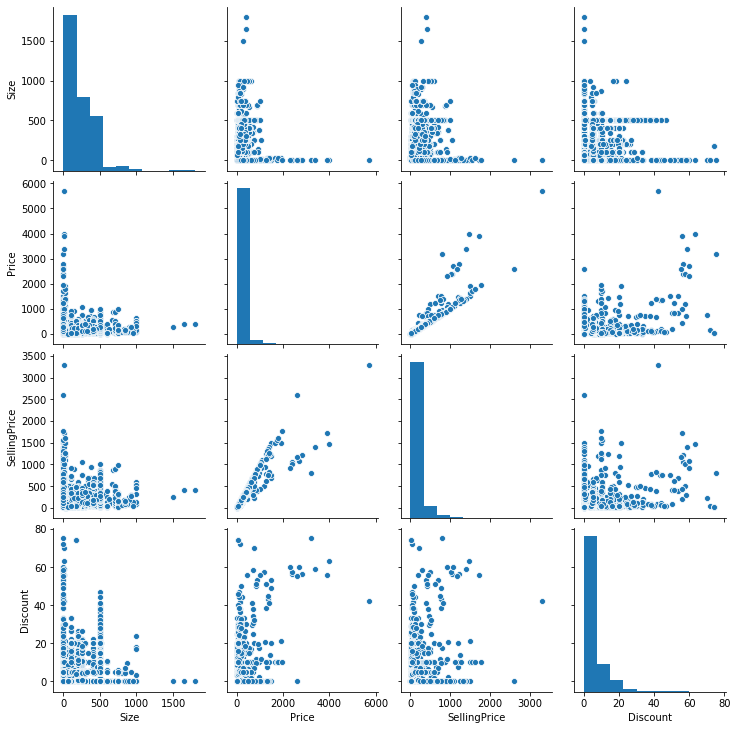

In [6]:
# Check how the data is scattered
sns.pairplot(df4)
plt.show()

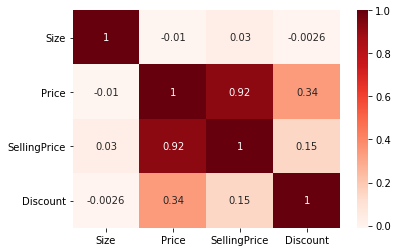

In [7]:
# Check the correlations
sns.heatmap(df4.corr(), cmap='Reds', annot=True)
plt.show()

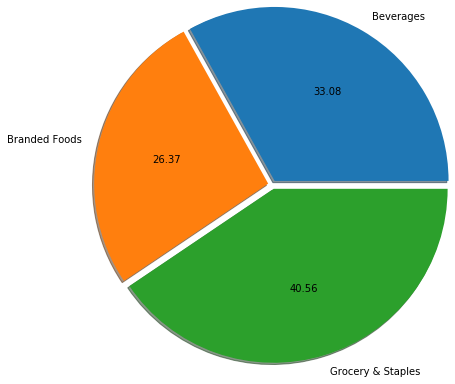

In [8]:
# Category-wise data mean price distribution
x = df4.groupby(['Category']).Price.mean().values
plt.pie(x, labels = df4.Category.unique(), explode=[0.05 for i in range(len(x))], radius=2, shadow=True, autopct='%2.2f',)
plt.show()

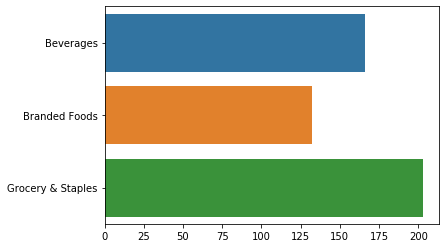

In [9]:
sns.barplot(x, y = df4.Category.unique())
plt.show()

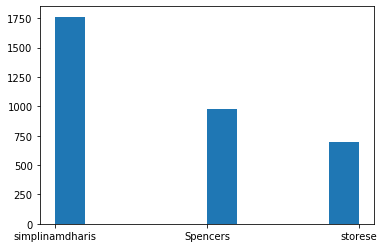

In [10]:
plt.hist(df4.Brand)
plt.show()

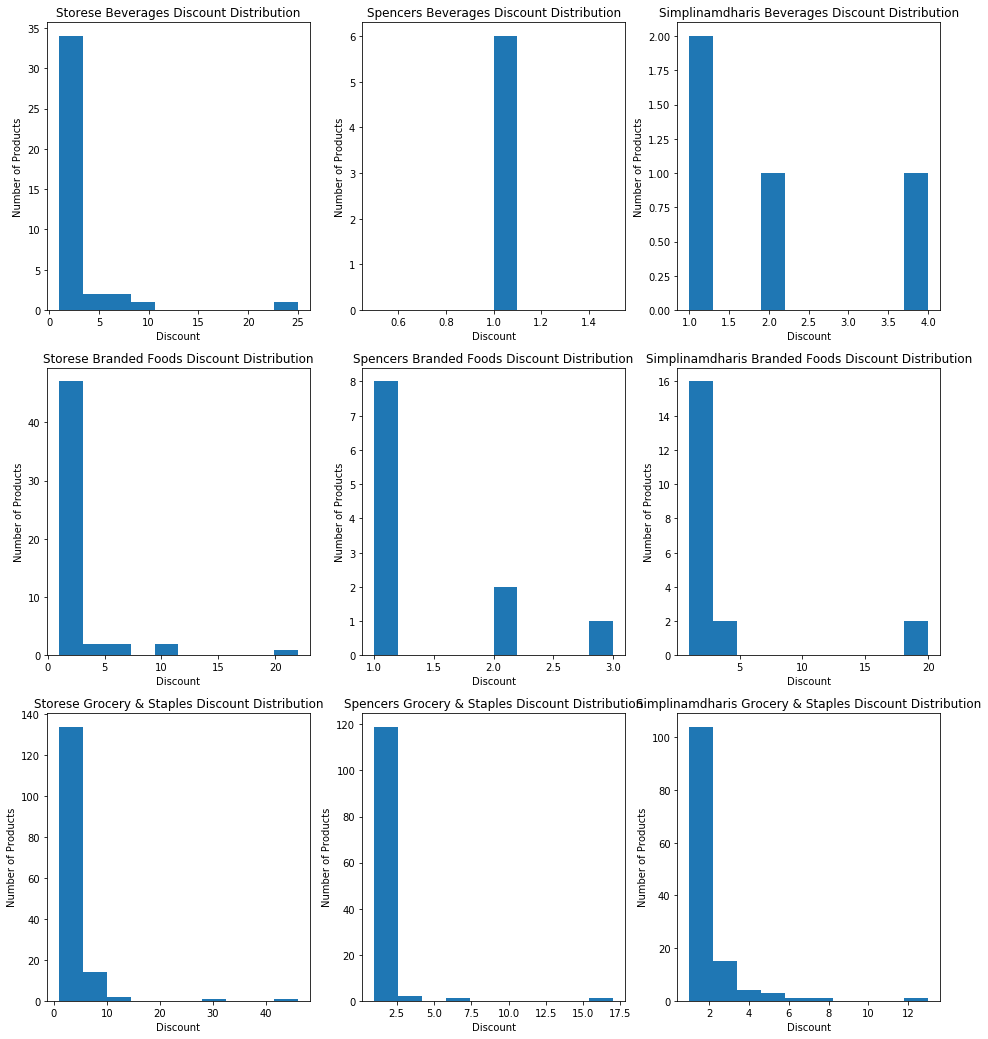

In [11]:
# Below grid shows the discount distribution across categories for each store
plt.figure(figsize=[16,18])

plt.subplot(3,3,1)
df_grocery = df4[(df4.Category == 'Beverages') & (df4.Brand=='storese') & (df4.Discount > 0)]
df_grocery.groupby('Discount').Name.count()
plt.hist(df_grocery.groupby('Discount').Name.count())
plt.xlabel('Discount')
plt.ylabel('Number of Products')
plt.title('Storese Beverages Discount Distribution')

plt.subplot(3,3,2)
df_grocery = df4[(df4.Category == 'Beverages') & (df4.Brand=='Spencers') & (df4.Discount > 0)]
df_grocery.groupby('Discount').Name.count()
plt.hist(df_grocery.groupby('Discount').Name.count())
plt.xlabel('Discount')
plt.ylabel('Number of Products')
plt.title('Spencers Beverages Discount Distribution')

plt.subplot(3,3,3)
df_grocery = df4[(df4.Category == 'Beverages') & (df4.Brand=='simplinamdharis') & (df4.Discount > 0)]
df_grocery.groupby('Discount').Name.count()
plt.hist(df_grocery.groupby('Discount').Name.count())
plt.xlabel('Discount')
plt.ylabel('Number of Products')
plt.title('Simplinamdharis Beverages Discount Distribution')

plt.subplot(3,3,4)
df_grocery = df4[(df4.Category == 'Branded Foods') & (df4.Brand=='storese') & (df4.Discount > 0)]
df_grocery.groupby('Discount').Name.count()
plt.hist(df_grocery.groupby('Discount').Name.count())
plt.xlabel('Discount')
plt.ylabel('Number of Products')
plt.title('Storese Branded Foods Discount Distribution')

plt.subplot(3,3,5)
df_grocery = df4[(df4.Category == 'Branded Foods') & (df4.Brand=='Spencers') & (df4.Discount > 0)]
df_grocery.groupby('Discount').Name.count()
plt.hist(df_grocery.groupby('Discount').Name.count())
plt.xlabel('Discount')
plt.ylabel('Number of Products')
plt.title('Spencers Branded Foods Discount Distribution')

plt.subplot(3,3,6)
df_grocery = df4[(df4.Category == 'Branded Foods') & (df4.Brand=='simplinamdharis') & (df4.Discount > 0)]
df_grocery.groupby('Discount').Name.count()
plt.hist(df_grocery.groupby('Discount').Name.count())
plt.xlabel('Discount')
plt.ylabel('Number of Products')
plt.title('Simplinamdharis Branded Foods Discount Distribution')

plt.subplot(3,3,7)
df_grocery = df4[(df4.Category == 'Grocery & Staples') & (df4.Brand=='storese') & (df4.Discount > 0)]
df_grocery.groupby('Discount').Name.count()
plt.hist(df_grocery.groupby('Discount').Name.count())
plt.xlabel('Discount')
plt.ylabel('Number of Products')
plt.title('Storese Grocery & Staples Discount Distribution')

plt.subplot(3,3,8)
df_grocery = df4[(df4.Category == 'Grocery & Staples') & (df4.Brand=='Spencers') & (df4.Discount > 0)]
df_grocery.groupby('Discount').Name.count()
plt.hist(df_grocery.groupby('Discount').Name.count())
plt.xlabel('Discount')
plt.ylabel('Number of Products')
plt.title('Spencers Grocery & Staples Discount Distribution')

plt.subplot(3,3,9)
df_grocery = df4[(df4.Category == 'Grocery & Staples') & (df4.Brand=='simplinamdharis') & (df4.Discount > 0)]
df_grocery.groupby('Discount').Name.count()
plt.hist(df_grocery.groupby('Discount').Name.count())
plt.xlabel('Discount')
plt.ylabel('Number of Products')
plt.title('Simplinamdharis Grocery & Staples Discount Distribution')
plt.show()

# 1. Show the number of products per category from all 3 stores ?

In [12]:
#Number of items each store has based on Category
#Group By Brand and then Category and count the total categroies for each brand
df4.groupby(['Brand']).Category.value_counts() #sum function

Brand            Category         
Spencers         Branded Foods        416
                 Grocery & Staples    336
                 Beverages            226
simplinamdharis  Branded Foods        943
                 Grocery & Staples    606
                 Beverages            214
storese          Grocery & Staples    460
                 Branded Foods        132
                 Beverages            103
Name: Category, dtype: int64

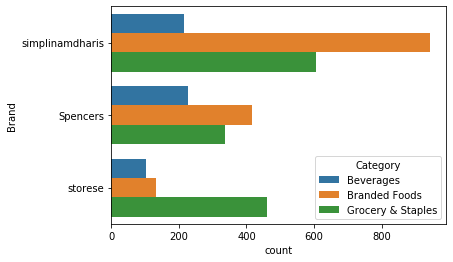

In [13]:
ax = sns.countplot(y="Brand", hue="Category", data=df4)

In [14]:
# As can be seen, Namdharis has the higest collection of products followed by Spencors and Storese
pd.crosstab(df4.Brand, df4.Category, margins=True, margins_name="Total")

Category,Beverages,Branded Foods,Grocery & Staples,Total
Brand,,,,
Spencers,226,416,336,978
simplinamdharis,214,943,606,1763
storese,103,132,460,695
Total,543,1491,1402,3436


# 2. How the Discount is distributed for different categories among all stores ?

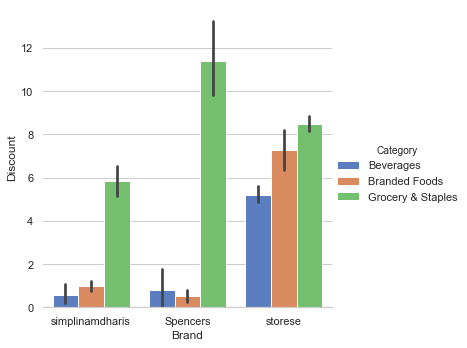

In [15]:
sns.set(style="whitegrid")
# Discount split between brands and categories
g = sns.catplot(x="Brand", y="Discount", hue="Category", data=df4, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Discount")

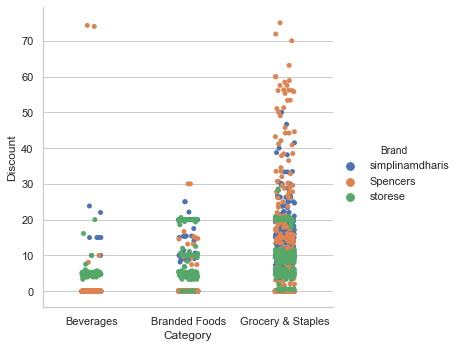

In [16]:
sns.catplot(x="Category", y="Discount", hue="Brand", data=df4);

Inference : Discount with Grocery & Staples Category is usually more than Branded Food & Beverages among all 3 stores.

# 3. Which Store is offering maximum discount for which category of food item ?

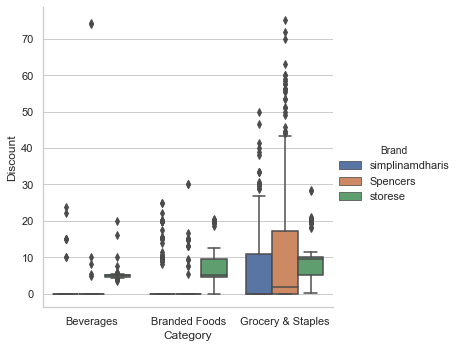

In [17]:
sns.catplot(x="Category", y="Discount", hue="Brand", kind="box", data=df4);

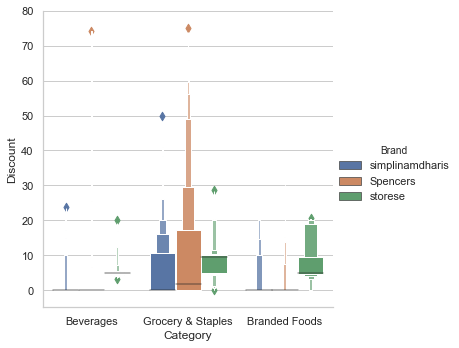

In [18]:
sns.catplot(x="Category", y="Discount", hue="Brand", kind="boxen",
            data=df4.sort_values("Discount"));

Inference: Spencor store with Grocery & Staples as category is offering maximum discount

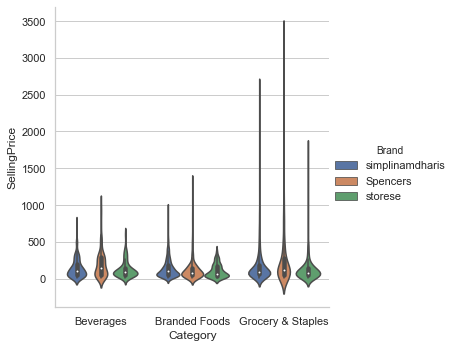

In [19]:
sns.catplot(x="Category", y="SellingPrice", hue="Brand",
            kind="violin", data=df4);

The above graph combines a boxplot with the kernel density estimation procedure.

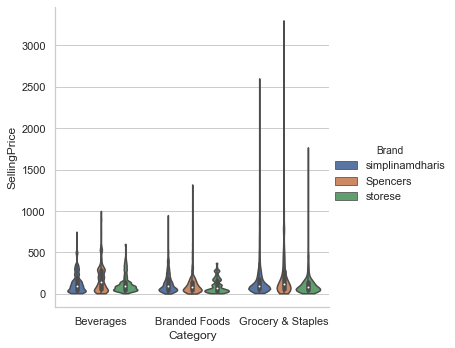

In [20]:
sns.catplot(x="Category", y="SellingPrice", hue="Brand",
            kind="violin", bw=.15, cut=0,
            data=df4);

This approach uses the kernel density estimate to provide a richer description of the distribution of values. Additionally, the quartile and whisker values from the boxplot are shown inside the violin

It’s also possible to “split” the violins when the hue parameter has only two levels, which can allow for a more efficient use of space:

# 4. Visualize the general variation between discounts at all 3 stores based on categories they sell.

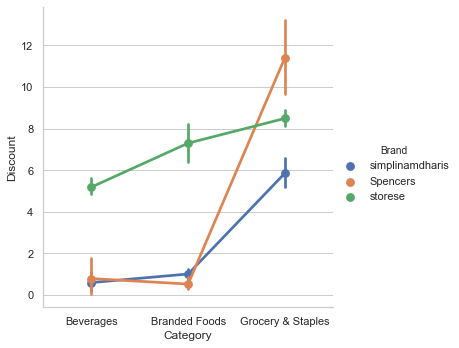

In [21]:
sns.catplot(x="Category", y="Discount", hue="Brand", kind="point", data=df4);

Pointplot() connects points from the same hue category. This makes it easy to see how the main relationship is changing as a function of the hue semantic, because our eyes are quite good at picking up on differences of slopes:

While the categorical functions lack the style semantic of the relational functions, it can still be a good idea to vary the marker and/or linestyle along with the hue to make figures that are maximally accessible and reproduce well in black and white:

# 5. What are the maximum discounts based on different categories and store?

In [22]:
#Top 5 discounted products offered among all three different stores
pd.DataFrame(df4.groupby(['Brand','Category']).Discount.max()) #Max function

Discount
Brand           Category                   
Spencers        Beverages             74.29
                Branded Foods         30.00
                Grocery & Staples     75.03
simplinamdharis Beverages             23.81
                Branded Foods         25.00
                Grocery & Staples     50.00
storese         Beverages             20.00
                Branded Foods         20.59
                Grocery & Staples     28.57

## Test out the products available before going for the recommendation

In [23]:
from ipywidgets import interact, Combobox
import re
# Interactive dropdown with a combo of both typing and select
def searchProduct(Product):
    pattern = '((^\s*\w+$))'
    matcher = re.compile(pattern)
    display(df4[(df4.Name.str.contains(Product, case=False))])
product = interact(searchProduct, Product = Combobox(options = df4.Name.tolist(),value=""))

interactive(children=(Combobox(value='', description='Product', options=('Kinley 500Ml - Coke', 'Kinley 1Ltr -…

In [25]:
# Run the cell, enter the product brand/name and size (ex. 400gm, 1ltr, etc.)
# Sample run output below, note that it is an infinite loop, enter N/n when prompted or restart/interrupt the kernel to break
while(True):
    product =  input("Enter the product name you wish to buy? E.g. Rice, Dal, etc.: ")
    size = input("Enter the approx. quantity you wish to buy (numbers only): ")
    pattern = '(.*(\w+).*)'
    matcher = re.compile(pattern)
    #data = df4[category]
    cols = ['Name', 'Brand', 'Size', 'Unit' ]
    items = df4[(df4.Name.str.contains(product, case=False)) & (df4.Size==float(size))]
    display('List of products matching the query', items)
    display('Best item as per the discounts offered', items[items.SellingPrice == items.SellingPrice.min()])
    proceed = input("Do you wish to continue? Y/N: ")
    if (proceed=='N') | (proceed=='n'):
        break
    else:
        continue

Enter the product name you wish to buy? E.g. Rice, Dal, etc.: orange
Enter the approx. quantity you wish to buy (numbers only): 1


'List of products matching the query'

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
33,100% Orange Juice - Tropicana,simplinamdharis,Beverages,1.0,ltr,135.0,135.0,0.00
3231,Fruit Drinks Orange Real 1 Ltr,storese,Beverages,1.0,ltr,99.0,94.0,5.05


'Best item as per the discounts offered'

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
3231,Fruit Drinks Orange Real 1 Ltr,storese,Beverages,1.0,ltr,99.0,94.0,5.05


Do you wish to continue? Y/N: y
Enter the product name you wish to buy? E.g. Rice, Dal, etc.: rice
Enter the approx. quantity you wish to buy (numbers only): 400


'List of products matching the query'

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
2285,MTR Rice Sevai 400g,Spencers,Branded Foods,400.0,gm,50.0,50.0,0.0
2883,Vermicelli Rice Sevai MTR 400Gms,storese,Grocery & Staples,400.0,gm,40.0,38.0,5.0


'Best item as per the discounts offered'

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
2883,Vermicelli Rice Sevai MTR 400Gms,storese,Grocery & Staples,400.0,gm,40.0,38.0,5.0


Do you wish to continue? Y/N: y
Enter the product name you wish to buy? E.g. Rice, Dal, etc.: wheat atta
Enter the approx. quantity you wish to buy (numbers only): 1


'List of products matching the query'

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
1169,Whole Wheat Atta Regular - Namdharis,simplinamdharis,Grocery & Staples,1.0,kg,45.0,39.0,13.33
1220,Whole Wheat Atta Select - Namdharis,simplinamdharis,Grocery & Staples,1.0,kg,49.0,42.0,14.29
1674,Wheat Atta Select - Aashirvaad,simplinamdharis,Grocery & Staples,1.0,kg,62.0,62.0,0.00
1780,Shyam's Agro fresh Whole Wheat Atta 1kg,Spencers,Grocery & Staples,1.0,kg,40.0,34.0,15.00


'Best item as per the discounts offered'

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
1780,Shyam's Agro fresh Whole Wheat Atta 1kg,Spencers,Grocery & Staples,1.0,kg,40.0,34.0,15.0


Do you wish to continue? Y/N: y
Enter the product name you wish to buy? E.g. Rice, Dal, etc.: kinley
Enter the approx. quantity you wish to buy (numbers only): 1


'List of products matching the query'

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
1,Kinley 1Ltr - Coke,simplinamdharis,Beverages,1.0,ltr,20.0,20.0,0.0
2674,Kinley Mineral Water 1L,Spencers,Beverages,1.0,ltr,20.0,20.0,0.0
3207,Kinley Mineral Water 1 Ltr,storese,Beverages,1.0,ltr,20.0,19.0,5.0


'Best item as per the discounts offered'

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
3207,Kinley Mineral Water 1 Ltr,storese,Beverages,1.0,ltr,20.0,19.0,5.0


Do you wish to continue? Y/N: y
Enter the product name you wish to buy? E.g. Rice, Dal, etc.: urad dal
Enter the approx. quantity you wish to buy (numbers only): 500


'List of products matching the query'

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
1167,Urad Dal Gota - Namdharis,simplinamdharis,Grocery & Staples,500.0,gm,76.0,69.0,9.21
1185,Urad Dal - Namdharis,simplinamdharis,Grocery & Staples,500.0,gm,82.0,69.0,15.85
1330,Phalada Organic Urad Dal Split 500G,simplinamdharis,Grocery & Staples,500.0,gm,110.0,110.0,0.00
1615,Urad Dal White Split - 24 Mantra,simplinamdharis,Grocery & Staples,500.0,gm,130.0,130.0,0.00
1732,Urad Dal - Namdharis Organic,simplinamdharis,Grocery & Staples,500.0,gm,110.0,99.0,10.00
2780,Urad Dal 24 Carat Town 500 Gms,storese,Grocery & Staples,500.0,gm,70.0,63.0,10.00
3024,Urad Dal Organic Town 500 Gms,storese,Grocery & Staples,500.0,gm,111.0,100.0,9.91
3190,Urad Dal Staff Town 500 Gms,storese,Grocery & Staples,500.0,gm,59.0,53.0,10.17


'Best item as per the discounts offered'

,Name,Brand,Category,Size,Unit,Price,SellingPrice,Discount
3190,Urad Dal Staff Town 500 Gms,storese,Grocery & Staples,500.0,gm,59.0,53.0,10.17


Do you wish to continue? Y/N: n
